In [87]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from cv2 import waitKey, destroyAllWindows
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights, raft_small, Raft_Small_Weights
from torchvision.utils import flow_to_image
from visualdl import LogWriter
import visualdl
device = "cuda" if torch.cuda.is_available() else "cpu"
logdir = "./log/scalar_test/train"
# 配置
image_folder = 'overDataSet4'  # 图片文件夹路径
image_test_folder = 'overDataSetTest'
output_folder = 'lightFlowOutput'  # 保存输出的光流文件夹路径
output_PRE_folder = 'lightFlowOutputPre' # 保存输出的预测图片文件夹路径
os.makedirs(output_folder, exist_ok=True)
os.makedirs(output_PRE_folder, exist_ok=True)

# 加载模型
weights1= Raft_Large_Weights.C_T_SKHT_K_V2
weights2= Raft_Small_Weights.DEFAULT
model = raft_large(weights=weights1, ).to(device)

# 获取所有训练集图片文件
image_files = sorted(glob.glob(os.path.join(image_folder, '*.PNG')))
# 针对数字进行排序
image_files = sorted(image_files, key=lambda x: int((os.path.basename(x).split('.')[0]).split('_')[-1]))
num_frames = len(image_files)

# 获取所有测试集图片文件
test_image_files = sorted(glob.glob(os.path.join(image_test_folder, '*.PNG')))
# 针对数字进行排序
test_image_files = sorted(test_image_files, key=lambda x: int((os.path.basename(x).split('.')[0]).split('_')[-1]))
num_test_frames = len(test_image_files)
print(num_frames)
print(num_test_frames)

576
288


特征编码器的主要作用是从图像中提取有效的特征。由于雷达回波图像与自然图像不同，你可以重点再训练该部分，以便模型更好地捕捉雷达图像的独特模式。具体建议：

第一个卷积层：这一层接收输入图像，因此可以重新训练 convnormrelu 层，使其适应雷达图像中的颜色或纹理信息。
后续的残差块（ResidualBlock）：这些层通过不同的层次学习到越来越抽象的特征。再训练这些层，可以帮助模型更好地提取雷达回波的高层次特征。

In [81]:
# 设置要训练的层
for name, param in model.named_parameters():
    if 'convnormrelu' in name:  # 要训练的层
        param.requires_grad = True  # 只训练这一层
    else:
        param.requires_grad = False  # 冻结其他层
        
LR = 0.0001
entropy_loss = nn.L1Loss()
entropy_loss.to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [82]:
# 帧预测函数
def apply_flow(image, flow):
    flow = flow.permute(0, 2, 3, 1)  # (N, H, W, 2)
    h, w = flow.shape[1:3]
    y_coords, x_coords = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
    y_coords, x_coords = y_coords.float(), x_coords.float()
    y_coords, x_coords = y_coords.to(flow.device), x_coords.to(flow.device)
    # 计算新的坐标
    new_x_coords = x_coords - flow[:, :, :, 0]
    new_y_coords = y_coords - flow[:, :, :, 1]
    # 归一化坐标
    new_x_coords = (new_x_coords / (w - 1)) * 2 - 1
    new_y_coords = (new_y_coords / (h - 1)) * 2 - 1
    
    # 使用bicubic插值采样
    grid = torch.stack([new_x_coords, new_y_coords], dim=-1)
    warped_image = torch.nn.functional.grid_sample(image, grid, mode='nearest', padding_mode='reflection', align_corners=True)
    
    mean_flow_x = flow[:, :, :, 0].mean()
    mean_flow_y = flow[:, :, :, 1].mean()
    return warped_image



max_flow_step = 5.0
step = 1

# 累加光流函数
def accumulate_flow(accumulated_flow, new_flow):
    return accumulated_flow + new_flow

# 限制光流步长函数
def limit_flow_step(flow, max_step):
    return torch.clamp(flow, min=-max_step, max=max_step)  # 限制光流的最大步长



In [28]:
# 开始训练
# def train():
#     for i in range(num_frames - step):
#         accumulated_flow = None  # 初始化累积光流为None
#         optimizer.zero_grad()  # 清除上一次迭代的梯度
#     
#         for j in range(step):
#             # 加载图片
#             img1 = Image.open(image_files[i + j]).convert('RGB')
#             img2 = Image.open(image_files[i + j + 1]).convert('RGB')
#     
#             img1_tensor = F.to_tensor(img1).unsqueeze(0).to(device)
#             img2_tensor = F.to_tensor(img2).unsqueeze(0).to(device)
#     
#             # 进行光流预测
#             list_of_flows = model(img1_tensor, img2_tensor)
#             predicted_flows = list_of_flows[-1]  # 获取光流
#     
#             if accumulated_flow is None:
#                 accumulated_flow = predicted_flows * (j / 10.0)  # 初始化累积光流
#             else:
#                 accumulated_flow = accumulate_flow(accumulated_flow, predicted_flows * (j / 10.0))  # 叠加光流
#             if j == step - 1:
#                 try:
#                     img3 = Image.open(image_files[i + j + 2]).convert('RGB')
#                     img3_tensor = F.to_tensor(img3).unsqueeze(0).to(device)
#                 except IndexError:
#                     print('No image found')
#     
#         # 使用光流进行帧预测
#         predicted_next_frame = apply_flow(img2_tensor, accumulated_flow)
#     
#         # 计算损失（光流叠加后的图像与实际图像的差异）
#         loss = entropy_loss(predicted_next_frame, img3_tensor)
#     
#         # 反向传播和优化
#         loss.backward()  # 计算梯度
#         # optimizer.step()  # 更新权重
#     
#         print(f"Processed frame {i} to {i+step}, loss: {loss.item()}")
#         with LogWriter(logdir=logdir) as writer:
#             # 向记录器添加一个tag为`loss`的数据
#             writer.add_scalar(tag="loss"+f"Epoch{epoch}", step=i, value=loss.item())


查看折线图：Terminal：visualdl --logdir ./log --port 8080

In [29]:
# from visualdl.server import app
# # visualdl.server.app.run(logdir,
# #                         host="127.0.0.1",
# #                         port=8080,
# #                         cache_timeout=20,
# #                         language=None,
# #                         public_path=None,
# #                         api_only=False,
# #                         open_browser=False)
# 
# app.run(logdir=logdir, port=8080, open_browser=True)
# 
# 
# for epoch in range(0,30):
#     None
#     train()

In [83]:
torch.save(model.state_dict(), 'Model/RAFTPRE.pth')
model = model.eval()

In [84]:
# 训练集生成以及帧预测
print(num_frames)
flowsToTrain = []
for i in range(num_frames - step):
#for i in range(20):
    accumulated_flow = None  # 每次更新i初始化累积光流为None
    for j in range(step):
        img1 = Image.open(image_files[i + j]).convert('RGB')
        img2 = Image.open(image_files[i + j + 1]).convert('RGB')
        
        img1_tensor = F.to_tensor(img1).unsqueeze(0)
        img2_tensor = F.to_tensor(img2).unsqueeze(0)

        # img1_tensor, img2_tensor = preprocess(img1_tensor, img2_tensor)

        with torch.no_grad():
            list_of_flows = model(img1_tensor.to(device), img2_tensor.to(device))
            predicted_flows = list_of_flows[-1].cpu()# 获取光流（一般来说最后一个最准确）
            
        # 限制光流移动步长
        # predicted_flows = limit_flow_step(predicted_flows, max_flow_step)
        
        if accumulated_flow is None:
            accumulated_flow = predicted_flows  # 如果是第一帧光流，初始化累积光流
        else:
            accumulated_flow = accumulate_flow(accumulated_flow, predicted_flows*(j/10.0))  # 叠加光流，以1/6，2/6……的方式叠加
        
        flowToTrain = accumulated_flow.squeeze()# [2, 192, 192]
        flowsToTrain.append(flowToTrain)
    


    flow_imgs = flow_to_image(accumulated_flow)
    
    # 保存光流结果
    output_file = os.path.join(output_folder, f'accumulated_flow_{i:03d}_to_{i+step:03d}.png')
    plt.imsave(output_file, flow_imgs.squeeze().permute(1, 2, 0).numpy())
    if i % 100 == 0:
        print(f"Processed frame {i} to {i+step}")

    
    # 进行帧预测
    predicted_next_frame = apply_flow(img2_tensor, accumulated_flow)
    output_file = os.path.join(output_PRE_folder, f'predicted{i+step+1:03d}using{i:03d}to{i+step:03d}.png')
    predicted_next_frame = predicted_next_frame.squeeze().permute(1, 2, 0).clamp(0, 1)
    plt.imsave(output_file, predicted_next_frame.numpy())
    
print("All Trainframes processed.")
flowsToTrain = torch.stack(flowsToTrain).numpy()# [num_frames - step, 2, 192, 192]

576
Processed frame 0 to 1
Processed frame 100 to 101
Processed frame 200 to 201
Processed frame 300 to 301
Processed frame 400 to 401
Processed frame 500 to 501
All frames processed.


In [94]:
# 测试集生成
flowsToTest = []
for i in range(num_test_frames - step):
    accumulated_flow = None
    for j in range(step):
        img1 = Image.open(test_image_files[i + j]).convert('RGB')
        img2 = Image.open(test_image_files[i + j + 1]).convert('RGB')
        
        img1_tensor = F.to_tensor(img1).unsqueeze(0)
        img2_tensor = F.to_tensor(img2).unsqueeze(0)
        
        # img1_tensor, img2_tensor = preprocess(img1_tensor, img2_tensor)

        with torch.no_grad():
            list_of_flows = model(img1_tensor.to(device), img2_tensor.to(device))
            predicted_flows = list_of_flows[-1].cpu()# 获取光流（一般来说最后一个最准确）
            
        # 限制光流移动步长
        # predicted_flows = limit_flow_step(predicted_flows, max_flow_step)
        
        if accumulated_flow is None:
            accumulated_flow = predicted_flows  # 如果是第一帧光流，初始化累积光流
        else:
            accumulated_flow = accumulate_flow(accumulated_flow, predicted_flows*(j/10.0))  # 叠加光流，以1/6，2/6……的方式叠加
        
        flowToTest = accumulated_flow.squeeze()# [2, 192, 192]
        flowsToTest.append(flowToTest)
        if i % 50 == 0:
            print(f"Processed frame {i} to {i+step}")
        
print("All Testframes processed.")
flowsToTest = torch.stack(flowsToTest).numpy()# [num_frames - step, 2, 192, 192]

Processed frame 0 to 1
Processed frame 50 to 51
Processed frame 100 to 101
Processed frame 150 to 151
Processed frame 200 to 201
Processed frame 250 to 251
All Testframes processed.


# 进行flow训练


In [95]:
from torch.utils.data import DataLoader
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')


class FlowPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(FlowPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # 全连接层，输出维度为2（光流的两个分量）
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # 前向传播LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # 取最后一个时间步的输出
        out = out[:, -1, :]
        
        # 全连接层
        out = self.fc(out)
        return out

Device: cuda


In [96]:
import random


def prepare_data(flows, seq_length):
    X, Y = [], []
    for i in range(len(flows) - seq_length):
        X.append(flows[i:i+seq_length])
        Y.append(flows[i+seq_length])
        
    X = np.stack(X)
    Y = np.stack(Y)
    
        # 展平每个时间步的光流数据
    X = X.reshape(X.shape[0], X.shape[1], -1)
    Y = Y.reshape(Y.shape[0], -1)
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

def create_dataloader(X, Y, batch_size):
    indices = list(range(len(X)))
    random.shuffle(indices)  # 打乱索引
    batches = [indices[i:i + batch_size] for i in range(0, len(indices), batch_size)]
    
    dataloader = []
    for batch_indices in batches:
        batch_X = X[batch_indices]
        batch_Y = Y[batch_indices]
        dataloader.append((batch_X, batch_Y))
    
    return dataloader
# 假设 flows 是一个包含多个光流序列的列表
seq_length = 5  # 每个样本的序列长度
# X:torch.Size([570, 5,192*192*2])
# Y:torch.Size([570,192*192*2])
X, Y = prepare_data(flowsToTrain, seq_length)
X_test, Y_test = prepare_data(flowsToTest, seq_length)
print(X.shape, Y.shape)
print(X_test.shape, Y_test.shape)


torch.Size([570, 5, 73728]) torch.Size([570, 73728])
torch.Size([282, 5, 73728]) torch.Size([282, 73728])


In [97]:
model = FlowPredictor(input_dim=192*192*2, hidden_dim=256, output_dim=192 * 192 * 2, num_layers=2)
model.to(device)
criterion = nn.SmoothL1Loss()  # 均方误差损失
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
LR = 0.0001

# 创建 DataLoader
dataset = torch.utils.data.TensorDataset(X, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
def train():
    model.train()
    lossnum = 0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossnum += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{len(dataloader)}], LossTrain: {lossnum/len(dataloader)}')

def test():
    model.eval()
    lossnum = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(testloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            lossnum += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{len(dataloader)}], LossTest: {lossnum/len(dataloader)}')

In [100]:
batch_size = 32
num_epochs = 30
for epoch in range(num_epochs):
    dataloader = create_dataloader(X, Y, batch_size)
    testloader = create_dataloader(X_test, Y_test, batch_size)
    train()
    test()


Epoch [1/30], Step [18], LossTrain: 0.07727689627144071
Epoch [1/30], Step [18], LossTest: 0.05158823852737745
Epoch [2/30], Step [18], LossTrain: 0.07716885478132302
Epoch [2/30], Step [18], LossTest: 0.05109946719474263
Epoch [3/30], Step [18], LossTrain: 0.07826417436202367
Epoch [3/30], Step [18], LossTest: 0.05274179908964369
Epoch [4/30], Step [18], LossTrain: 0.0797919070141183
Epoch [4/30], Step [18], LossTest: 0.05180372090803252
Epoch [5/30], Step [18], LossTrain: 0.07807590005298455
Epoch [5/30], Step [18], LossTest: 0.04822108108136389
Epoch [6/30], Step [18], LossTrain: 0.07742125127050611
Epoch [6/30], Step [18], LossTest: 0.049140567580858864
Epoch [7/30], Step [18], LossTrain: 0.07835532559288873
Epoch [7/30], Step [18], LossTest: 0.048887786351972155
Epoch [8/30], Step [18], LossTrain: 0.07613168263600932
Epoch [8/30], Step [18], LossTest: 0.04966614105635219
Epoch [9/30], Step [18], LossTrain: 0.07599198445677757
Epoch [9/30], Step [18], LossTest: 0.05289351112312741


In [99]:
torch.save(model.state_dict(), 'Model/flowPre.pth')
model = model.eval()

C:\Users\BLKDASH\AppData\Local\Temp\ipykernel_35548\2514295780.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Model/flowPre.pth'))


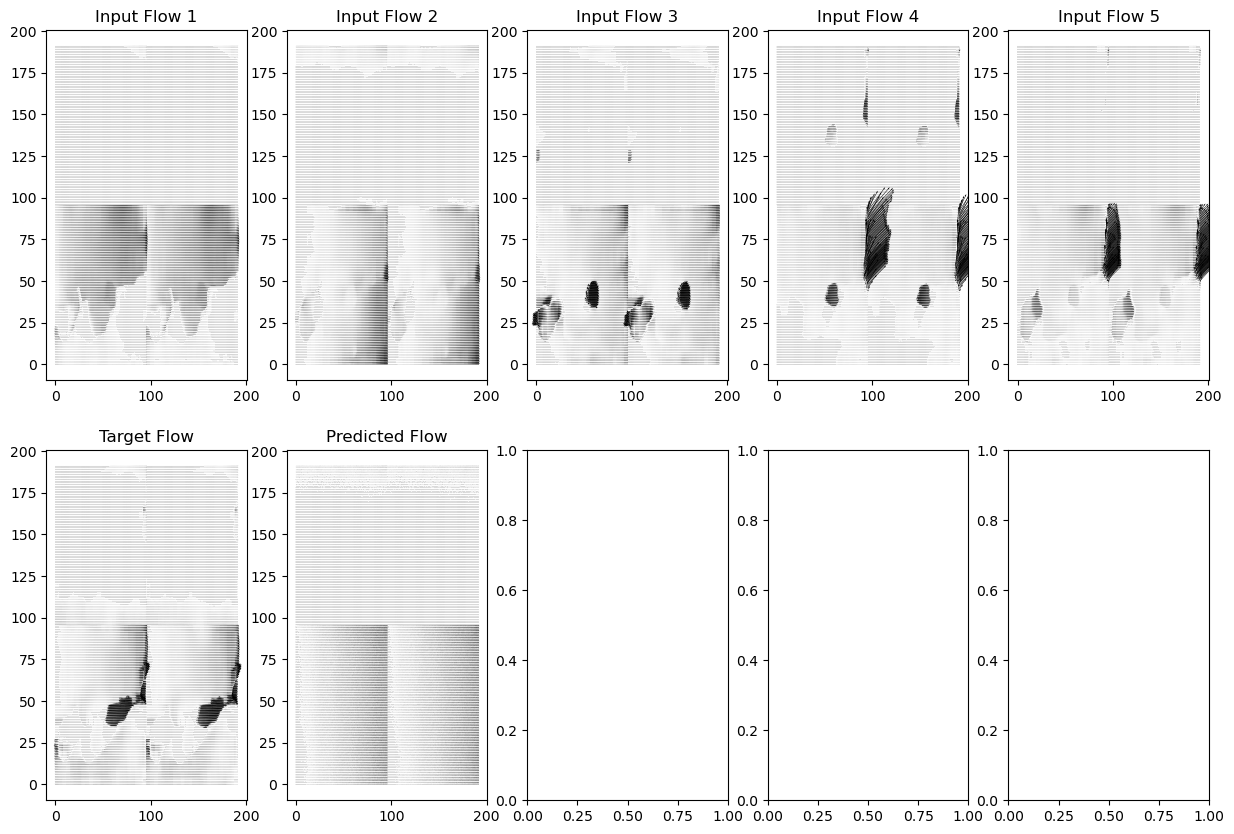

In [111]:
model.load_state_dict(torch.load('Model/flowPre.pth'))
model.eval()

def visualize_flow_sequence(inputs, target, prediction, height, width):
    inputs = inputs.cpu().numpy().reshape(-1, height, width, 2)
    target = target.cpu().numpy().reshape(height, width, 2)
    prediction = prediction.cpu().numpy().reshape(height, width, 2)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 10))
    
    for i in range(5):
        ax = axes[0, i % 5]
        ax.quiver(inputs[i, :, :, 0], inputs[i, :, :, 1])
        ax.set_title(f'Input Flow {i+1}')
    
    axes[1, 0].quiver(target[:, :, 0], target[:, :, 1])
    axes[1, 0].set_title('Target Flow')
    
    axes[1, 1].quiver(prediction[:, :, 0], prediction[:, :, 1])
    axes[1, 1].set_title('Predicted Flow')
    
    plt.show()
    
    
# 选择一个测试样本
with torch.no_grad():
    inputs, targets = next(iter(create_dataloader(X_test, Y_test, batch_size)))
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # 前向传播
    predictions = model(inputs)
    
    # 选择第一个样本进行可视化
    input_sample = inputs[0]
    target_sample = targets[0]
    prediction_sample = predictions[0]
    
    visualize_flow_sequence(input_sample, target_sample, prediction_sample, 192, 192)